# Model Selection v0 work<br>
This notebook details the model selection process for the 7 day mortality risk prediction model to be used with Carepoint Hospice Tool. The models evaluated in below include Logistic Regression with L1 Lasso regularization, Logistic Regression with L2 Ridge regularization, k Nearest Neighbors classifiers, and a Decision Tree classifier. Feature selection was automated in a sklearn pipeline using GridSearchCV(), with the cross validation set at 5 folds. Additionally, 2 methods for missing data were evaluated for each potential model and hyperparameter setting: Imputation of the column medians for each missing value, and all missing values set at 0.<BR><BR>
    **Objectives:**<br>
1. Identify optimal hyperparameter structure for models.<br>
2. Determine most appropriate missing data imputation method. <br>
3. Explore the impact the number of features has on model performance.<br>
4. Identify AUC target for first iteration of Risk Model. 

In [1]:
%matplotlib inline
#load libraries
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier #baseline model
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier 

from IPython.display import display #displays full dataframe columns
#display all dataframe columns when printed
pd.options.display.max_columns = None

C:\tooling\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load data
df = pd.read_csv('C:/Users/Mark.Burghart/Documents/projects/hospice_carepoint/data/transformed/carepoint_transformed_dummied.csv', index_col=0)
df.shape

(271541, 120)

### Train/Test Split<br><br>
Splitting main dataframe by 70/30 split, leaving ~190,000 visits for training/cross validation. Remaining 30% of data will be held out from all model building, hyperparamenter tuning, and feature selection and will be solely used to determine the final model's performance. After model is tested on holdout set, no changes to model will be made.


In [3]:
#separate variables (X) from outcome of interest (y)
df.shape
cols = df.columns.get_values() #converts column names to list
cols = cols.tolist()
feature_cols = [x for x in cols if x != 'death_within_7_days'] #removes outcome of interest from list ('death_within_7_days')

#extract rows
#print(feature_cols) #debug
X = df.loc[:, feature_cols]
X.shape #outcome column has been removed

(271541, 119)

In [4]:
#save outcome variable as y
y = df.death_within_7_days
y.shape

(271541,)

In [5]:
#separate data into training/test (aka holdout) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 23) #random_state for reproducibility (if needed)
#X_test, y_test should not be used until NO MORE decisions are being made. This is the final, FINAL validation, and more often just used for model performance and generalizability!

<br> 
# Pipepline for imputation, feature selection, and model training/tuning<br><br>
### Missing Data: Median imputation<br><br>

#### Logistic Regression with L1 Lasso Penalty, imputation = Median columnar value


First up: Logistic Regression models. Going to try both L1 and L2 Regularization.<br><br>
Note: For *MISSING DATA*,  I am **IMPUTING THE MEDIAN COLUMN VALUE**, as opposed to setting to 0, or kNN imputation as of now.

In [6]:
kbest = SelectKBest(f_classif) #select best 'k' features
logreg = LogisticRegression(penalty = 'l1', random_state = 0) #L1 Regularization
impute = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0) #impute missing values: replacing NaNs with Median Column value for each column

#Pipeline for Logistic Regression with L1 Lasso Regularization
pipe_lr_l1 = Pipeline([('imputer', impute),
                       ('kbest', kbest),
                      ('lr', logreg)])

In [7]:
#parameters for grid search cross validation 
parameters = {'kbest__k': [5, 10, 20,40, 60], #building models with 40, 60, 80, and 100 most significant variables
                 'lr__C' : [0.01, 0.1, 1, 10, 100]} #tuning C for logistic regression

In [8]:
#grid search
grid = GridSearchCV(pipe_lr_l1, parameters, cv = 5, scoring = 'roc_auc') #run grid on parameters, 5-fold cross validation, AUC is evaluation metric

In [9]:
%%time
#fit models
grid.fit(X_train,y_train)


C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

Wall time: 41min 21s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 10, 20, 40, 60], 'lr__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Model interpretations:<br><br>
feature [86] is constant, meaning the value is constant for all visits and patients (and should be removed from model).<br><br>
true_divide warning is likely due to feature[86], and is trying to divide by 0 variance...



In [10]:
print("Best estimator:\n{}".format(grid.best_estimator_)) #prints best model and pipeline
print("Logistic Regression step:\n{}".format(grid.best_estimator_.named_steps["lr"])) #prints logistic regression step of pipeline
print("Logistic Regression coefficients:\n{}".format(grid.best_estimator_.named_steps["lr"].coef_)) #prints coefficients of best estimator
print("Best Parameters: {}".format(grid.best_params_)) #outputs best parameters settings
print("Best cross validation score: {:.2f}".format(grid.best_score_)) #best produced cross validation score

Best estimator:
Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=60, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Logistic Regression step:
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression coefficients:
[[ 9.52683832e-04 -1.32666922e-01  1.19567914e-01  1.69686820e-01
  -1.01592255e-02  9.30324824e-02  5.69836653e-02  9.69037316e-02
  -4.59095858e-03  4.14169229e-02  1.53879735e

In [11]:
#AUC scores for each training set run
print("Grid scores on training set: ")
means = grid.cv_results_['mean_train_score']
stds = grid.cv_results_['std_train_score']

for mean, std, params in zip(means, stds, grid.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))
    
#AUC scores for each validation set run
print("Grid scores on Development set: ")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

Grid scores on training set: 
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.01}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.1}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 1}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 10}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 100}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.01}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.1}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 1}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 10}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 100}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 0.01}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 0.1}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 1}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 10}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 100}
0.807 (+/-0.000) for {'kbest__k': 40, 'lr__C': 0.01}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C': 0.1}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C': 1}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C':

C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [12]:
#return variables of significance
#start with 40
fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=0)
imputed_X_train = pd.DataFrame(fill_NaN.fit_transform(X_train))
imputed_X_train.columns = X_train.columns
imputed_X_train.index = X_train.index

#display columns...

In [13]:
#return variables of significance
#Return 100 features used in best model
selector = SelectKBest(f_classif, k = 100)
selector.fit(imputed_X_train, y_train)
features = imputed_X_train.columns[selector.get_support()]
print(features)
scores = selector.scores_ #saves scores of features
print(scores)

Index(['gender', 'Anxiety', 'Depression', 'Drowsiness', 'Lack_of_Appetite',
       'Nausea', 'Pain', 'Shortness_of_Breath', 'Tiredness', 'Wellbeing',
       'LengthOfCare_days', '3_visit_max_anxiety', '3_visit_max_depression',
       '3_visit_max_drowsiness', '3_visit_max_lackofappetite',
       '3_visit_max_nausea', '3_visit_max_pain',
       '3_visit_max_shortnessofbreath', '3_visit_max_tiredness',
       '3_visit_max_wellbeing', '5_visit_max_anxiety',
       '5_visit_max_depression', '5_visit_max_drowsiness',
       '5_visit_max_lackofappetite', '5_visit_max_nausea', '5_visit_max_pain',
       '5_visit_max_shortnessofbreath', '5_visit_max_tiredness',
       '5_visit_max_wellbeing', '3_visit_mean_anxiety',
       '3_visit_mean_depression', '3_visit_mean_drowsiness',
       '3_visit_mean_lackofappetite', '3_visit_mean_nausea',
       '3_visit_mean_pain', '3_visit_mean_shortnessofbreath',
       '3_visit_mean_tiredness', '3_visit_mean_wellbeing',
       '5_visit_mean_depression', '5_vi

**Logistic Regression with L1 penalty and median missing data imputation** <br><br>
- Best model selected used parameters K = 100 (100 variables included), and C = 1 for LogReg model. 
- AUC scores ranged from 0.807 (40 variables, C = 0.01-100) to 0.817

#### Logistic Regression with L2 Ridge Penalty, imputation = Median columnar value

In [53]:
#Logistic regression with L2 Regularization penalty
kbest = SelectKBest(f_classif) #select best 'k' features
logreg_l2 = LogisticRegression(penalty = 'l2', random_state = 0) #L2 Ridge Regularization
impute = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0) #impute missing values: replacing NaNs with Median Column value for each column

#Pipeline for Logistic Regression with L2 'Ridge' Regularization
pipe_lr_l2 = Pipeline([('imputer', impute),
                       ('kbest', kbest),
                      ('lr', logreg_l2)])
#parameters for grid search cross validation 
parameters = {'kbest__k': [5, 10, 20, 40, 60], #building models with 40, 60, 80, and 100 most significant variables
                 'lr__C' : [0.01, 0.1, 1, 10, 100]} #tuning C for logistic regression

#grid search
grid_l2 = GridSearchCV(pipe_lr_l2, parameters, cv = 5, scoring = 'roc_auc') #run grid on parameters, 5-fold cross validation, AUC is evaluation metric



In [54]:
%%time
#fit models
grid_l2.fit(X_train,y_train)

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

Wall time: 18min 43s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 10, 20, 40, 60], 'lr__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [55]:
print("Best estimator:\n{}".format(grid_l2.best_estimator_)) #prints best model and pipeline
print("Logistic Regression step:\n{}".format(grid_l2.best_estimator_.named_steps["lr"])) #prints logistic regression step of pipeline
print("Logistic Regression coefficients:\n{}".format(grid_l2.best_estimator_.named_steps["lr"].coef_)) #prints coefficients of best estimator
print("Best Parameters: {}".format(grid_l2.best_params_)) #outputs best parameters settings
print("Best cross validation score: {:.2f}".format(grid_l2.best_score_)) #best produced cross validation score

Best estimator:
Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=60, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Logistic Regression step:
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression coefficients:
[[ 8.48669711e-04 -1.32466987e-01  1.19507325e-01  1.69695960e-01
  -1.00971379e-02  9.30824113e-02  5.72070777e-02  9.71376716e-02
  -4.58782396e-03  4.17210402e-02  1.53928058e-0

In [56]:
#AUC scores for each training set run
print("Grid scores on Training set: ")
means = grid_l2.cv_results_['mean_train_score']
stds = grid_l2.cv_results_['std_train_score']

for mean, std, params in zip(means, stds, grid_l2.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

#AUC scores for each validation set run
print("Grid scores on Development set: ")
means = grid_l2.cv_results_['mean_test_score']
stds = grid_l2.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_l2.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

Grid scores on Training set: 
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.01}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.1}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 1}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 10}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 100}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.01}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.1}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 1}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 10}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 100}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 0.01}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 0.1}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 1}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 10}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 100}
0.807 (+/-0.000) for {'kbest__k': 40, 'lr__C': 0.01}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C': 0.1}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C': 1}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C':

C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<Br>**Logistic Regression with L2 penalty and median missing data imputation**<br><br>
- Best model selected used parameters K = 100 (100 variables included), and C = 10 for LogReg model. <br>
- AUC scores ranged from 0.807 (40 variables, C = 0.01-100) to 0.817 
- Interestingly, these outputs produced the same AUC across all cross validation trials as L1 model.
    -Only difference was C = 1 for L1. 
    - Could be due to same random_state parameter?<br>
    <br>
    
    Also interesting to note that adding 60 additional variables only improves AUC by ~1%. 100 variables is likely overfitting...
    <br><Br>
    Not sure why the training and test validation scores are exactly the same...


#### kNearest Neighbors


In [18]:
%%time
# creating odd list of K for KNN
neighbors = [1,3,5,7]

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, imputed_X_train, y_train, cv=5, scoring='roc_auc') #using median imputed dataset for training
    cv_scores.append(scores.mean())

Wall time: 49min 13s


The optimal number of neighbors is 7


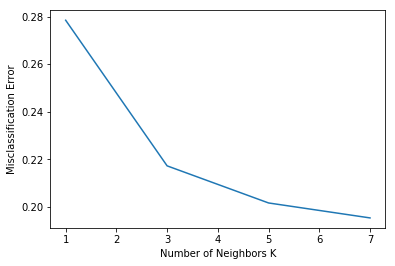

[0.80191911 0.80626449 0.80662309 0.80448436 0.80376759]


In [24]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print(scores)

#### Decision Tree


In [20]:
#decision tree model
tree = DecisionTreeClassifier(random_state = 0) #maximum depth of 5 leaves
kbest = SelectKBest(f_classif) #select best 'k' features
impute = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0) #impute missing values: replacing NaNs with Median Column value for each column

#Pipeline for Logistic Regression with L2 'Ridge' Regularization
pipe_tree = Pipeline([('imputer', impute),
                       ('kbest', kbest),
                      ('dec_tree', tree)])
#parameters for grid search cross validation 
parameters = {'kbest__k': [5, 10, 20, 40, 60], #building models with 40, 60, 80, and 100 most significant variables
                 'dec_tree__max_depth' : [2,3,4,5]} #tuning tree depth for performance vs understanding

#grid search
grid_tree = GridSearchCV(pipe_tree, parameters, cv = 5, scoring = 'roc_auc') #run grid on parameters, 5-fold cross validation, AUC is evaluation metric

In [21]:
%%time
#fit models
grid_tree.fit(X_train,y_train)


C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

Wall time: 7min


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001D758DF30D0>)), ('dec_tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=N...         min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 10, 20, 40, 60], 'dec_tree__max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [23]:
print("Best estimator:\n{}".format(grid_tree.best_estimator_)) #prints best model and pipeline
print("Decision Tree step:\n{}".format(grid_tree.best_estimator_.named_steps["dec_tree"])) #prints logistic regression step of pipeline
#print("Logistic Regression coefficients:\n{}".format(grid_tree.best_estimator_.named_steps["dec_tree"].coef_)) #prints coefficients of best estimator
print("Best Parameters: {}".format(grid_tree.best_params_)) #outputs best parameters settings
print("Best cross validation score: {:.2f}".format(grid_tree.best_score_)) #best produced cross validation score

Best estimator:
Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=60, score_func=<function f_classif at 0x000001D758DF30D0>)), ('dec_tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None...         min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])
Decision Tree step:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
Best Parameters: {'dec_tree__max_depth': 5, 'kbest__k': 60}
Best cross validation score: 0.80


In [25]:
#AUC scores for each training set run
print("Grid scores on Development set: ")
means = grid_tree.cv_results_['mean_train_score']
stds = grid_tree.cv_results_['std_train_score']

for mean, std, params in zip(means, stds, grid_tree.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

#AUC scores for each validation set run
print("Grid scores on Development set: ")
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_tree.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

Grid scores on Development set: 
0.731 (+/-0.001) for {'dec_tree__max_depth': 2, 'kbest__k': 5}
0.731 (+/-0.001) for {'dec_tree__max_depth': 2, 'kbest__k': 10}
0.731 (+/-0.001) for {'dec_tree__max_depth': 2, 'kbest__k': 20}
0.731 (+/-0.001) for {'dec_tree__max_depth': 2, 'kbest__k': 40}
0.731 (+/-0.001) for {'dec_tree__max_depth': 2, 'kbest__k': 60}
0.766 (+/-0.001) for {'dec_tree__max_depth': 3, 'kbest__k': 5}
0.766 (+/-0.001) for {'dec_tree__max_depth': 3, 'kbest__k': 10}
0.751 (+/-0.001) for {'dec_tree__max_depth': 3, 'kbest__k': 20}
0.752 (+/-0.001) for {'dec_tree__max_depth': 3, 'kbest__k': 40}
0.752 (+/-0.001) for {'dec_tree__max_depth': 3, 'kbest__k': 60}
0.783 (+/-0.001) for {'dec_tree__max_depth': 4, 'kbest__k': 5}
0.783 (+/-0.001) for {'dec_tree__max_depth': 4, 'kbest__k': 10}
0.780 (+/-0.001) for {'dec_tree__max_depth': 4, 'kbest__k': 20}
0.781 (+/-0.001) for {'dec_tree__max_depth': 4, 'kbest__k': 40}
0.781 (+/-0.001) for {'dec_tree__max_depth': 4, 'kbest__k': 60}
0.795 (+/-

C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Missing Data: '0' fills

In [37]:
#can't pipeline is_na = 0, so will need to do manually for X_train, y_train
X_train_zero = X_train.fillna(0)
y_train_zero = y_train.fillna(0)
#use these objects for cross validation, and remove 'impute' methods from any pipelines

#### Logistic Regression with L1 Lasso Penalty, missing data filled with '0'

In [38]:
kbest = SelectKBest(f_classif) #select best 'k' features
logreg = LogisticRegression(penalty = 'l1', random_state = 0) #L1 Regularization

#Pipeline for Logistic Regression with L1 Lasso Regularization
pipe_lr_l1 = Pipeline([('kbest', kbest),
                      ('lr', logreg)])

#parameters for grid search cross validation 
parameters = {'kbest__k': [5, 10, 20,40, 60, 100], #building models with 40, 60, 80, and 100 most significant variables
                 'lr__C' : [0.01, 0.1, 1, 10, 100]} #tuning C for logistic regression

#grid search
grid_l1 = GridSearchCV(pipe_lr_l1, parameters, cv = 5, scoring = 'roc_auc') #run grid on parameters, 5-fold cross validation, AUC is evaluation metric

In [39]:
%%time
#fit model on missing data = 0 training set
grid_l1.fit(X_train_zero,y_train_zero)

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

Wall time: 14min 10s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 10, 20, 40, 60, 100], 'lr__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [40]:
print("Best estimator:\n{}".format(grid_l1.best_estimator_)) #prints best model and pipeline
print("Logistic Regression step:\n{}".format(grid_l1.best_estimator_.named_steps["lr"])) #prints logistic regression step of pipeline
print("Logistic Regression coefficients:\n{}".format(grid_l1.best_estimator_.named_steps["lr"].coef_)) #prints coefficients of best estimator
print("Best Parameters: {}".format(grid_l1.best_params_)) #outputs best parameters settings
print("Best cross validation score: {:.2f}".format(grid_l1.best_score_)) #best produced cross validation score

Best estimator:
Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=100, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Logistic Regression step:
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression coefficients:
[[-1.32341561e-01  1.81731940e-02 -1.77457827e-01  1.50869695e-01
   1.24549568e-01 -4.74059342e-02  1.60517218e-02  1.06199762e-01
  -4.33025264e-02 -3.77252291e-03 -5.21727590e-03 -4.17332787e-02
   1.27063412e-02 -2.98212161e-02 -3.68404459e-02  8.42054997e-02
   1.302

In [41]:
#AUC scores for each training set run
print("Grid scores on training set: ")
means = grid_l1.cv_results_['mean_train_score']
stds = grid_l1.cv_results_['std_train_score']

for mean, std, params in zip(means, stds, grid_l1.cv_results_['params']): 
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))
    
#AUC scores for each validation set run
print("Grid scores on Development set: ")
means = grid_l1.cv_results_['mean_test_score']
stds = grid_l1.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_l1.cv_results_['params']): 
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

Grid scores on training set: 
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.01}
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.1}
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 1}
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 10}
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 100}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.01}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.1}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 1}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 10}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 100}
0.749 (+/-0.004) for {'kbest__k': 20, 'lr__C': 0.01}
0.749 (+/-0.005) for {'kbest__k': 20, 'lr__C': 0.1}
0.749 (+/-0.005) for {'kbest__k': 20, 'lr__C': 1}
0.749 (+/-0.005) for {'kbest__k': 20, 'lr__C': 10}
0.749 (+/-0.005) for {'kbest__k': 20, 'lr__C': 100}
0.759 (+/-0.001) for {'kbest__k': 40, 'lr__C': 0.01}
0.759 (+/-0.001) for {'kbest__k': 40, 'lr__C': 0.1}
0.759 (+/-0.001) for {'kbest__k': 40, 'lr__C': 1}
0.759 (+/-0.001) for {'kbest__k': 40, 'lr__C':

C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


#### Logistic Regression with L2 Ridge Penalty, missing data = 0

In [57]:
#Logistic regression with L2 Regularization penalty
kbest = SelectKBest(f_classif) #select best 'k' features
logreg_l2 = LogisticRegression(penalty = 'l2', random_state = 0) #L2 Ridge Regularization

#Pipeline for Logistic Regression with L2 'Ridge' Regularization
pipe_lr_l2 = Pipeline([('kbest', kbest),
                      ('lr', logreg_l2)])
#parameters for grid search cross validation 
parameters = {'kbest__k': [5, 10, 20, 40, 60, 100], #building models with 40, 60, 80, and 100 most significant variables
                 'lr__C' : [0.01, 0.1, 1, 10, 100]} #tuning C for logistic regression

#grid search
grid_l2 = GridSearchCV(pipe_lr_l2, parameters, cv = 5, scoring = 'roc_auc') #run grid on parameters, 5-fold cross validation, AUC is evaluation metric


In [58]:
%%time
#fit models
grid_l2.fit(X_train_zero,y_train_zero)

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

Wall time: 17min 24s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 10, 20, 40, 60, 100], 'lr__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [59]:
print("Best estimator:\n{}".format(grid_l2.best_estimator_)) #prints best model and pipeline
print("Logistic Regression step:\n{}".format(grid_l2.best_estimator_.named_steps["lr"])) #prints logistic regression step of pipeline
print("Logistic Regression coefficients:\n{}".format(grid_l2.best_estimator_.named_steps["lr"].coef_)) #prints coefficients of best estimator
print("Best Parameters: {}".format(grid_l2.best_params_)) #outputs best parameters settings
print("Best cross validation score: {:.2f}".format(grid_l2.best_score_)) #best produced cross validation score

Best estimator:
Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=100, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Logistic Regression step:
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression coefficients:
[[-1.34150004e-01  1.75154671e-02 -1.76953989e-01  1.50851119e-01
   1.24340841e-01 -4.78980494e-02  1.61794858e-02  1.06309585e-01
  -4.34248082e-02 -3.70721713e-03 -5.23990210e-03 -4.03387263e-02
   1.37042960e-02 -3.06641391e-02 -3.67139997e-02  8.41951754e-02
   1.3

In [60]:
#AUC scores for each training set run
print("Grid scores on training set: ")
means = grid_l2.cv_results_['mean_train_score']
stds = grid_l2.cv_results_['std_train_score']

for mean, std, params in zip(means, stds, grid_l2.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

#AUC scores for each validation set run
print("Grid scores on Development set: ")
means = grid_l2.cv_results_['mean_test_score']
stds = grid_l2.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_l2.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

Grid scores on training set: 
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.01}
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.1}
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 1}
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 10}
0.703 (+/-0.001) for {'kbest__k': 5, 'lr__C': 100}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.01}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.1}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 1}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 10}
0.732 (+/-0.001) for {'kbest__k': 10, 'lr__C': 100}
0.749 (+/-0.005) for {'kbest__k': 20, 'lr__C': 0.01}
0.749 (+/-0.005) for {'kbest__k': 20, 'lr__C': 0.1}
0.749 (+/-0.005) for {'kbest__k': 20, 'lr__C': 1}
0.749 (+/-0.005) for {'kbest__k': 20, 'lr__C': 10}
0.749 (+/-0.005) for {'kbest__k': 20, 'lr__C': 100}
0.759 (+/-0.001) for {'kbest__k': 40, 'lr__C': 0.01}
0.759 (+/-0.001) for {'kbest__k': 40, 'lr__C': 0.1}
0.759 (+/-0.001) for {'kbest__k': 40, 'lr__C': 1}
0.759 (+/-0.001) for {'kbest__k': 40, 'lr__C':

C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


#### kNearest Neighbors<br><br>
Missing data = 0

In [46]:
%%time
# creating odd list of K for KNN
neighbors = [1,3,5,7,9,11]

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_zero, y_train_zero, cv=5, scoring='roc_auc') #using median imputed dataset for training
    cv_scores.append(scores.mean())

Wall time: 48min 32s


The optimal number of neighbors is 11


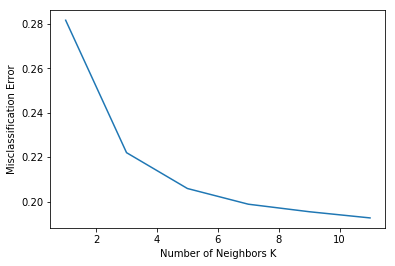

[0.80608308 0.8080598  0.80982286 0.80678216 0.80617784]


In [47]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print(scores)

#### Decision Tree with 0 as missing value

In [48]:
#decision tree model
tree = DecisionTreeClassifier(random_state = 0) #maximum depth of 5 leaves
kbest = SelectKBest(f_classif) #select best 'k' features

#Pipeline for Logistic Regression with L2 'Ridge' Regularization
pipe_tree = Pipeline([('kbest', kbest),
                      ('dec_tree', tree)])
#parameters for grid search cross validation 
parameters = {'kbest__k': [5, 10, 20, 40, 60, 100], #building models with 40, 60, 80, and 100 most significant variables
                 'dec_tree__max_depth' : [2,3,4,5]} #tuning tree depth for performance vs understanding

#grid search
grid_tree = GridSearchCV(pipe_tree, parameters, cv = 5, scoring = 'roc_auc') #run grid on parameters, 5-fold cross validation, AUC is evaluation metric

In [49]:
%%time
#fit models
grid_tree.fit(X_train_zero,y_train_zero)

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

Wall time: 2min 39s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001D758DF30D0>)), ('dec_tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 10, 20, 40, 60, 100], 'dec_tree__max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [50]:
print("Best estimator:\n{}".format(grid_tree.best_estimator_)) #prints best model and pipeline
print("Decision Tree step:\n{}".format(grid_tree.best_estimator_.named_steps["dec_tree"])) #prints logistic regression step of pipeline
#print("Logistic Regression coefficients:\n{}".format(grid_tree.best_estimator_.named_steps["dec_tree"].coef_)) #prints coefficients of best estimator
print("Best Parameters: {}".format(grid_tree.best_params_)) #outputs best parameters settings
print("Best cross validation score: {:.2f}".format(grid_tree.best_score_)) #best produced cross validation score

Best estimator:
Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=100, score_func=<function f_classif at 0x000001D758DF30D0>)), ('dec_tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])
Decision Tree step:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
Best Parameters: {'dec_tree__max_depth': 5, 'kbest__k': 100}
Best cross validation score: 0.79


In [51]:
#AUC scores for each training set run
print("Grid scores on Development set: ")
means = grid_tree.cv_results_['mean_train_score']
stds = grid_tree.cv_results_['std_train_score']

for mean, std, params in zip(means, stds, grid_tree.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

#AUC scores for each validation set run
print("Grid scores on Development set: ")
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_tree.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

Grid scores on Development set: 
0.681 (+/-0.001) for {'dec_tree__max_depth': 2, 'kbest__k': 5}
0.710 (+/-0.047) for {'dec_tree__max_depth': 2, 'kbest__k': 10}
0.710 (+/-0.047) for {'dec_tree__max_depth': 2, 'kbest__k': 20}
0.710 (+/-0.047) for {'dec_tree__max_depth': 2, 'kbest__k': 40}
0.710 (+/-0.047) for {'dec_tree__max_depth': 2, 'kbest__k': 60}
0.710 (+/-0.047) for {'dec_tree__max_depth': 2, 'kbest__k': 100}
0.713 (+/-0.001) for {'dec_tree__max_depth': 3, 'kbest__k': 5}
0.745 (+/-0.009) for {'dec_tree__max_depth': 3, 'kbest__k': 10}
0.750 (+/-0.016) for {'dec_tree__max_depth': 3, 'kbest__k': 20}
0.751 (+/-0.018) for {'dec_tree__max_depth': 3, 'kbest__k': 40}
0.751 (+/-0.018) for {'dec_tree__max_depth': 3, 'kbest__k': 60}
0.751 (+/-0.018) for {'dec_tree__max_depth': 3, 'kbest__k': 100}
0.747 (+/-0.000) for {'dec_tree__max_depth': 4, 'kbest__k': 5}
0.762 (+/-0.013) for {'dec_tree__max_depth': 4, 'kbest__k': 10}
0.768 (+/-0.008) for {'dec_tree__max_depth': 4, 'kbest__k': 20}
0.771 (+

C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


# Conclusions of this Notebook:
<BR><BR>
    **Objectives:**<br>
1. Identify optimal hyperparameter structure for models.<br>
2. Determine most appropriate missing data imputation method. <br>
3. Explore the impact the number of features has on model performance.<br>
4. Identify AUC target for first iteration of Risk Model. <br><br>



1. Optimal parameter structures for each model type has been finalized. For L1 Logistic Regression, the optimal C parameter was 100. For L2 Logistic Regression, the optimal C parameter was 10.<br><br>
    
2. The most accurate imputation method tested was imputing the columnar median values, rather than setting each NaN to '0'. Moving forward, both methods will be tested on final versions of models, as I'm not currently sure if calculating median values for all missing data is possible in database. It should, but for transparency sake, I should continue testing.<br><br>

3. I think I need to do more statistically-based feature reduction, as opposed to automating that process. while a chi-square independence test won't work, ANOVA will and I can use significant p-values to find significance. My only worry is that with so much data, there will be a lot of significant features to build into the model (like 100s). But then again, maybe that is necessary... I'll keep experimenting. I think taking a more statistical approach to feature selection will improve clinical trust of the model, as right now I am explicitly selecting the most informative 20,40,60,etc features to be included in each iteration, but can't say if those features are consistently used across model due to the cross validation and grid search methods. The best approach long-term is to imbed the feature selection process into modeling pipeline, as this is true machine learning/data mining, but I think it would be best to build trust in our process first. <br><br>

4. I think I have a decent idea for models and parameters to officially try without the pipeline and grid search methods used above. It seems like I am getting pretty good performance with a limited number of features included in the model, which is great. The decision tree above was able to score an AUC of .73 using a depth of 2 and only 5 features... That's pretty incredible. Additionally, the logistic regressions had an AUC of .75 with only 5 features, which is great. <br><br>

Additionally, **I think our target AUC should be around 0.77 for working production model**. kNN, decision tree (even short), and both regressions produced this AUC with little features used. While we can expect a reduction in performance when applied to truly new data, I think an AUC starting around 0.77 is great, with a cap at 0.83 for production-level testing. I think that can be attained relatively easily, and reduces the amount of risk of overtraining features to this dataset, thus reducing the accuracy of the model in production and increases computational processing time. Anything higher than 0.83 for our first testing of this risk model begins to push into the overfitting territory. I'd prefer to be a little more cautious at this stage and then iterate with new model and features, pushing AUC higher.<br><br>



**NEXT STEPS**: Pursue some statistically-focused feature selection to aide in the interpretation of the model and reduce computational strain. Test final versions of models, again with cross validation, and calculate performance metrics for each version.